# Calculation of Plomp test score for signal (55 dB + SNR) and noise (55 dB), both with ISTS spectrum, in front of a subject with normal AC thresholds (125 Hz - 8 kHz)

12 May 2022 GC

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
from math import log10 as log10

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
def read_AC_thresholds():
    # function to read threshold in dB SPL op de eardrum
    f_in = '/media/guido/LACIE/Cingle_Guido/Master/Headband/AC_normal_thr_third.xlsx'
    p_in = Path(f_in)   
    df = pd.read_excel(p_in, sheet_name='AC_normal_thr_eardrum', header=0, nrows=1)
    df = df.drop(['Unnamed: 0', 'Study_ID', 'Device', '125_Hz'], axis=1)
    return df

In [4]:
def read_ISTS_SPL():
    # function to read ISTS dB SPL for 1/3 thirdbands, 65 dB & 55 dB
    f_in = '/media/guido/LACIE/Cingle_Guido/Master/Implant/Primary_data/constants.xlsx'
    p_in = Path(f_in)   
    df = pd.read_excel(p_in, sheet_name='ISTS_sound_pressure', header=0, nrows=2)
    df = df.fillna(pd.NA)
    df = df.rename(columns={'Unnamed: 0' : 'Signal'})
    df = df.set_index(['Signal'])
    df = df.drop('125_Hz', axis = 1)
    s65 = pd.Series(df.iloc[0])
    s55 = pd.Series(df.iloc[1])
    return (s65, s55)

In [5]:
def read_HRTF():
    # function to read HRTF data for the AC path, collected by Stenfelt
    f_in = '/media/guido/LACIE/Cingle_Guido/Master/Implant/Primary_data/constants.xlsx'
    p_in = Path(f_in)   
    df = pd.read_excel(p_in, sheet_name='HRTF_KEMAR_Stenfelt', header=0, nrows=3)
    df = df.fillna(pd.NA)
    df = df.rename(columns={'Unnamed: 0' : 'Angle'})
    df = df.set_index(['Angle'])
    df = df.drop('125_Hz', axis = 1)
    df = df.round(1)
    s0 = pd.Series(df.iloc[0])
    s90 = pd.Series(df.iloc[1])
    s270 = pd.Series(df.iloc[2])
    return (s0, s90, s270)

In [6]:
def read_HRTF_BCD():
    # function to read HRTF data for the BC path, collected by Stenfelt
    f_in = '/media/guido/LACIE/Cingle_Guido/Master/Implant/Primary_data/constants.xlsx'
    p_in = Path(f_in)   
    df = pd.read_excel(p_in, sheet_name='HRTF_BAHA_Stenfelt', header=0, nrows=3)
    #df = df.drop(['Unnamed: 0'], axis=1)
    df = df.fillna(pd.NA)
    df = df.rename(columns={'Unnamed: 0' : 'Angle'})
    df = df.set_index(['Angle'])
    df = df.drop('125_Hz', axis = 1)
    df = df.round(1)
    s0 = pd.Series(df.iloc[0])
    s90 = pd.Series(df.iloc[1])
    s270 = pd.Series(df.iloc[2])
    return (s0, s90, s270)

In [7]:
def ISTS_HRTF_65():
    # ISTS 65 dB corrected with HRTF for 0, 90 and 270 degrees, return list of 3 pd.Series
    ists65 = read_ISTS_SPL()[0]
    hrtf = read_HRTF()
    res = list()
    for s in hrtf:
        corr = s + ists65
        res.append(corr)
    return res

In [8]:
def ISTS_HRTF_55():
    # ISTS 55 dB corrected with HRTF for 0, 90 and 270 degrees, return list of 3 pd.Series
    ists55 = read_ISTS_SPL()[1]
    hrtf = read_HRTF()
    res = list()
    for s in hrtf:
        corr = s + ists55
        res.append(corr)
    return res

In [9]:
def read_ANSI():
    # function to read data from tabel 3 from ANSI norm
    f_in = '/media/guido/LACIE/Cingle_Guido/Master/Implant/Primary_data/constants.xlsx'
    p_in = Path(f_in)   
    df = pd.read_excel(p_in, sheet_name='Tabel3_SII', header=0, index_col=0)
    return df

In [10]:
def read_importance():
    # function to read importance values from xlsx file
    f_in = '/media/guido/LACIE/Cingle_Guido/Master/Implant/Primary_data/constants.xlsx'
    p_in = Path(f_in)    
    df = pd.read_excel(p_in, sheet_name='SII_importance_SPIN', header=0, nrows=1)
    df = df.drop(['Unnamed: 0', '125_Hz'], axis=1)
    df = df.fillna(pd.NA)
    s = pd.Series(df.iloc[0])
    return s

In [11]:
def energetic(db):
    # transformation of dB values in "energetic values"
    energy = 10**(db/10)
    return energy

In [12]:
def dB_calc(enrg):
    # transformation from "energetic values" to dB, input is pandas object
    bel = np.log10(enrg)
    decibel = 10 * bel
    return decibel

In [13]:
def band_audibility(sl):
    ba = (sl + 15) / 30
    ba = ba.fillna(-999)
    ba = ba.where(ba<=1, 1)
    ba = ba.replace(-999, 999)
    ba = ba.where(ba>=0, 0)
    ba = ba.replace(999, pd.NA)
    return ba

In [14]:
def band_intelligibility(sl):
    ba = band_audibility(sl)
    importance = read_importance()
    bi = ba * importance
    return bi

In [15]:
def speech_intelligibility_index(sl):
    bi = band_intelligibility(sl)
    SII = bi.sum(axis=1, min_count=18)
    SII = SII.round(4)
    return SII

In [16]:
def calculate_B(V, N):
    ''' calculation of B, Ansi S3.5 1997 4.3.2.2
    B is the larger value between equivalent noise spectrum level N 
    and self-speech masking spectrum level V'''
    b = pd.concat([V, N], axis='columns')
    l = list()
    for col in b.columns: 
        if col not in l: l.append(col)
    bb = pd.DataFrame()
    for col in l: 
        bb[col] = b[col].max(axis='columns')
    return bb

In [17]:
def calculate_C(V, N):   
    # calculation of C, slope of spread of masking, Ansi S3.5 1997 4.3.2.2
    B = calculate_B(V, N)
    l = list()
    c = pd.DataFrame()
    for col in B.columns: 
        f = (int(col.strip('_Hz')))  
        c[col] = -80 + 0.6 * (B[col] + 10 * log10(f) - 6.353)
    return c

In [18]:
def calculate_Z(V, N):   
    
    # calculation of Z, equivalent masking spectrum level, Ansi S3.5 1997 4.3.2.5
    b = calculate_B(V, N)
    c = calculate_C(V, N)

    # make list with values of CF of 1/3 octave bands (160-8000 Hz)
    clmns = b.columns
    l = list()
    for col in clmns: 
        f = (int(col.strip('_Hz')))
        l.append(f)     
    
    d ={0: (b.iloc[:, 0]).to_numpy()}    # make dict, value Z=B for 160 Hz, ANSI 4.3.2.4
    for i in range (1, 18):              # equation 9, i index f band > 160 Hz
        n2 = pd.array([0]*len(b))        # make null array for update with summation 

        for k in range (0, i-1):         # k, summation index, range 
            bb = (b.iloc[:, k]).to_numpy()
            cc = c.iloc[:, k].to_numpy()
            fi = l[i]
            fk = l[k]
            r = log10(0.89 * fi / fk)
            n3 = 10 ** (0.1 * (bb + 3.32 * cc * r))
            n2 += n3                     # summation term in eq.9

        n1 = 10 ** (0.1 * N.iloc[:, i])
        z = 10 * np.log10(n1 + n2)       # equation 9
        d1 = {i : z}
        d.update(d1)                     # dict {f : array z}   
    
    z = pd.DataFrame(d)                  # convert dict in DataFrame
    
    lc = clmns.to_list()                 # set back names 1/3 octave bands (eg 160_Hz)
    dc = dict()
    for j in range(len(lc)):  
        up = {j: lc[j]}
        dc.update(up)
    z = z.rename(columns=dc)
    
    return z

In [19]:
def calculate_X(thresholds):
    # calculation of X, equivalent internal noise for AC or BC path, Ansi S3.5 1997 4.4
    ansi = read_ANSI()
    internal_noise = ansi.iloc[:, 4]
    ff_eardrum_TF = ansi.iloc[:, 5]
    internal_noise_eardrum = internal_noise + ff_eardrum_TF
    x = thresholds.add(internal_noise_eardrum,  axis='columns')
    return x

In [20]:
def calculate_D(V, N, thresholds):
    # calculation of disturbance D, Ansi S3.5 1997 4.5
    Z = calculate_Z(V, N)
    X = calculate_X(thresholds)
    filter_x = (Z < X)
    take_x = X[filter_x]
    D = take_x.fillna(value=Z)
    return D

In [21]:
def unmasked_combination(unmasked_AC, unmasked_BC):
    # combination SL BC path & AC path
    energy_combi = unmasked_AC.apply(energetic) + unmasked_BC.apply(energetic)
    energy_combi = energy_combi.fillna(energetic(1000))
    sl_combi = dB_calc(energy_combi)
    sl_combi = sl_combi.replace(1000, pd.NA)
    return sl_combi

In [22]:
def order_columns(df):
    # set BC data low freq. = data at 250 Hz
    for f in ['160_Hz', '200_Hz']: df[f] = df['250_Hz']
    ordered_columns = ['160_Hz', '200_Hz', '250_Hz', '315_Hz', '400_Hz', '500_Hz', 
                       '630_Hz', '800_Hz', '1000_Hz', '1250_Hz', '1600_Hz', '2000_Hz', 
                       '2500_Hz', '3150_Hz', '4000_Hz', '5000_Hz', '6300_Hz', '8000_Hz']
    df = df[ordered_columns]
    return df

In [23]:
def sii_func_SNR(SNR):
    # Calculation of SII for AC path, as a funtion of signal to noise ratio SNR
    # read normal AC thresholds, at the tympanic membrane
    act = read_AC_thresholds()
    # speech spectrum level, HRTF for signal in front of subject
    e_65 = ISTS_HRTF_55()[0] + SNR
    E = pd.concat([e_65] * len(act), axis=1).T
    # calculation of self-speech masking spectrum level V, Ansi S3.5 1997 4.3.2.1
    V = E - 24 
    # noise = ISTS signal in front of subject
    # calculation of equivalent noise spectrum level N, Ansi S3.5 1997 4.3.2.2
    n = ISTS_HRTF_55()[0]
    N = pd.concat([n] * len(act), axis=1).T
    # calculation of disturbance D, Ansi S3.5 1997 4.5
    disturbance = calculate_D(V, N, act)
    # calculation of SII for AC path
    unmasked = E.subtract(disturbance, axis='columns') # ANSI step 7 (4.7) E - D
    sii = speech_intelligibility_index(unmasked)
    return sii.to_dict()[0]

In [24]:
def calc_sii_snr():
    snr = [*range(-15, 15, 1)]
    d = dict()
    for i in range(len(snr)):
        dd = {snr[i] : sii_func_SNR(snr[i])}
        d.update(dd)
    return pd.Series(d)

In [25]:
def plomp_transfer_function():
    sii = calc_sii_snr()
    # score plomp SPIN, calculation as a funtion of SII
    M = -4.7
    S = 1.19
    e = 2.71828
    snr = [*range(-15, 15, 1)]
    d = dict()
    for i in range(len(snr)):
        p = round(1/(1 + e**((M-snr[i])/S)), 3)
        dd = {snr[i] : p}
        d.update(dd)
    score = pd.Series(d)
    plomp = pd.DataFrame([sii,score]).T
    plomp.reset_index(inplace = True)
    plomp = plomp.rename(columns={'index' : 'SNR', 0 : 'SII', 1 : 'plomp-score'})
    return plomp

In [26]:
plp = plomp_transfer_function()
plp

,SNR,SII,plomp-score
0,-15,0.0000,0.000
1,-14,0.0273,0.000
2,-13,0.0607,0.001
3,-12,0.0940,0.002
4,-11,0.1273,0.005
5,-10,0.1606,0.012
6,-9,0.1940,0.026
7,-8,0.2273,0.059
8,-7,0.2606,0.126
9,-6,0.2940,0.251


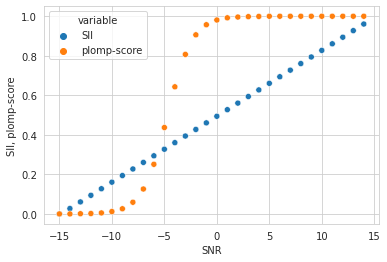

In [27]:
long = pd.melt(plp, id_vars='SNR', value_vars=['SII', 'plomp-score'], value_name='SII, plomp-score')
with sns.axes_style("whitegrid"):
    sns.scatterplot(x='SNR', y='SII, plomp-score', data=long, hue='variable')